In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from keras.layers.embeddings import Embedding

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

import ndac
%matplotlib inline

Using TensorFlow backend.


16082 samples input.
7667 samples above high value, 3324 samples below low value, 5091 samples removed.


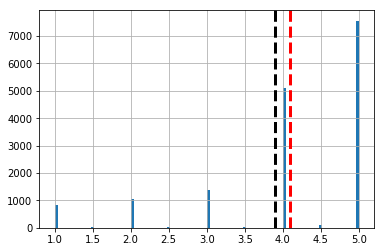

In [2]:
#read in the data and classify
data = pd.read_csv('dataframes/DF_solubility.csv', index_col=0)
data, hist = ndac.value_classify(data['solubility_class_1M'], data['aa_seq'], high_value=4.1, low_value=3.9)

In [3]:
# setup 'docs' for use with Tokenizer
def aa_seq_doc(aa_sequence):
    """This function takes in an amino acid sequence (aa sequence) and adds spaces between each amino acid."""
    
    return ' '.join([aa_sequence[i:i+1] 
                     for i in range(0, len(aa_sequence))])
data['aa_seq_doc'] = data['aa_seq'].apply(aa_seq_doc)
data = data[pd.notnull(data['aa_seq_doc'])]

# check shape
print('data shape: ', data.shape)

data shape:  (10991, 4)


In [4]:
# define sequence documents
docs = list(data['aa_seq_doc'])
# create the tokenizer
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(docs)

# integer encode documents
X = t.texts_to_sequences(docs)
y = data['class'].values

# fix random seed for reproducibility
np.random.seed(27315)

# load the dataset but only keep the top n words, zero the rest
top_words = len(t.word_index) + 1

# truncate and pad input sequences
seq_lengths = [len(seq) for seq in X]
max_seq_length = max(seq_lengths)
X = sequence.pad_sequences(X, maxlen=max_seq_length)

In [ ]:
# tune hyperparameters for simple model

# model based on "A C-LSTM Neural Network for Text Classification"

def create_model(embedding_length=16, num_filters=128, pool_size=2,
                 lstm_nodes=100, drop=0.5, recurrent_drop=0.5, filter_length=3):
    # create the model
    model = Sequential()
    model.add(Embedding(top_words, embedding_length, 
                        input_length=max_seq_length))
    model.add(Conv1D(filters=num_filters, kernel_size=filter_length, 
                     padding='same', activation='selu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(LSTM(lstm_nodes, dropout=drop, 
              recurrent_dropout=recurrent_drop))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])

    return model


model = KerasClassifier(build_fn=create_model, batch_size=64,
                        epochs=30, verbose=0)
# define the grid search parameters
# model hyperparameters
embedding_length = [8, 16]
num_filters = [100, 200]
filter_length = [6, 8, 10]
pool_size = [2, 4]
lstm_nodes = [100, 200]

param_grid = dict(num_filters=num_filters, pool_size=pool_size,
                  lstm_nodes=lstm_nodes, filter_length=filter_length, embedding_length=embedding_length)

grid = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=3, verbose=10)


grid_result = grid.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

grid_df = pd.DataFrame(grid_result.cv_results_['params'])
grid_df['mean'] = grid_result.cv_results_['mean_test_score']
grid_df['stddev'] = grid_result.cv_results_['std_test_score']

# print results to csv file
grid_df.to_csv('2018-06-21_aa_gird_search_solubility_results.csv')

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] embedding_length=8, filter_length=6, lstm_nodes=100, num_filters=100, pool_size=2 
[CV]  embedding_length=8, filter_length=6, lstm_nodes=100, num_filters=100, pool_size=2, score=0.7931222707423581, total= 7.7min
[CV] embedding_length=8, filter_length=6, lstm_nodes=100, num_filters=100, pool_size=2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.7min remaining:    0.0s


[CV]  embedding_length=8, filter_length=6, lstm_nodes=100, num_filters=100, pool_size=2, score=0.777292576419214, total= 7.5min
[CV] embedding_length=8, filter_length=6, lstm_nodes=100, num_filters=100, pool_size=2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 15.3min remaining:    0.0s


[CV]  embedding_length=8, filter_length=6, lstm_nodes=100, num_filters=100, pool_size=2, score=0.819819819852364, total= 7.5min
[CV] embedding_length=8, filter_length=6, lstm_nodes=100, num_filters=100, pool_size=4 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 22.8min remaining:    0.0s


[CV]  embedding_length=8, filter_length=6, lstm_nodes=100, num_filters=100, pool_size=4, score=0.8010371179039302, total= 4.6min
[CV] embedding_length=8, filter_length=6, lstm_nodes=100, num_filters=100, pool_size=4 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 27.5min remaining:    0.0s


[CV]  embedding_length=8, filter_length=6, lstm_nodes=100, num_filters=100, pool_size=4, score=0.7903930131004366, total= 4.6min
[CV] embedding_length=8, filter_length=6, lstm_nodes=100, num_filters=100, pool_size=4 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 32.1min remaining:    0.0s


[CV]  embedding_length=8, filter_length=6, lstm_nodes=100, num_filters=100, pool_size=4, score=0.8274638274800995, total= 4.5min
[CV] embedding_length=8, filter_length=6, lstm_nodes=100, num_filters=200, pool_size=2 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 36.7min remaining:    0.0s


[CV]  embedding_length=8, filter_length=6, lstm_nodes=100, num_filters=200, pool_size=2, score=0.8114082969432315, total= 9.2min
[CV] embedding_length=8, filter_length=6, lstm_nodes=100, num_filters=200, pool_size=2 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 45.9min remaining:    0.0s


[CV]  embedding_length=8, filter_length=6, lstm_nodes=100, num_filters=200, pool_size=2, score=0.7832969432314411, total= 9.1min
[CV] embedding_length=8, filter_length=6, lstm_nodes=100, num_filters=200, pool_size=2 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 55.2min remaining:    0.0s


[CV]  embedding_length=8, filter_length=6, lstm_nodes=100, num_filters=200, pool_size=2, score=0.8140868141193582, total= 9.3min
[CV] embedding_length=8, filter_length=6, lstm_nodes=100, num_filters=200, pool_size=4 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 64.6min remaining:    0.0s


[CV]  embedding_length=8, filter_length=6, lstm_nodes=100, num_filters=200, pool_size=4, score=0.7688318777292577, total= 5.7min
[CV] embedding_length=8, filter_length=6, lstm_nodes=100, num_filters=200, pool_size=4 
[CV]  embedding_length=8, filter_length=6, lstm_nodes=100, num_filters=200, pool_size=4, score=0.7838427947598253, total= 5.6min
[CV] embedding_length=8, filter_length=6, lstm_nodes=100, num_filters=200, pool_size=4 
[CV]  embedding_length=8, filter_length=6, lstm_nodes=100, num_filters=200, pool_size=4, score=0.8241878242366404, total= 5.7min
[CV] embedding_length=8, filter_length=6, lstm_nodes=200, num_filters=100, pool_size=2 
[CV]  embedding_length=8, filter_length=6, lstm_nodes=200, num_filters=100, pool_size=2, score=0.7933951965065502, total=15.0min
[CV] embedding_length=8, filter_length=6, lstm_nodes=200, num_filters=100, pool_size=2 
[CV]  embedding_length=8, filter_length=6, lstm_nodes=200, num_filters=100, pool_size=2, score=0.789028384279476, total=15.1min
[CV]

[CV]  embedding_length=8, filter_length=8, lstm_nodes=200, num_filters=200, pool_size=4, score=0.8168168168656331, total=10.7min
[CV] embedding_length=8, filter_length=10, lstm_nodes=100, num_filters=100, pool_size=2 
[CV]  embedding_length=8, filter_length=10, lstm_nodes=100, num_filters=100, pool_size=2, score=0.7707423580786026, total= 7.9min
[CV] embedding_length=8, filter_length=10, lstm_nodes=100, num_filters=100, pool_size=2 
[CV]  embedding_length=8, filter_length=10, lstm_nodes=100, num_filters=100, pool_size=2, score=0.7895742358078602, total= 7.9min
[CV] embedding_length=8, filter_length=10, lstm_nodes=100, num_filters=100, pool_size=2 
[CV]  embedding_length=8, filter_length=10, lstm_nodes=100, num_filters=100, pool_size=2, score=0.8214578214903656, total= 7.8min
[CV] embedding_length=8, filter_length=10, lstm_nodes=100, num_filters=100, pool_size=4 
[CV]  embedding_length=8, filter_length=10, lstm_nodes=100, num_filters=100, pool_size=4, score=0.7966703056768559, total= 4.